In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
plt.rcParams["figure.figsize"] = (15,15)

In [2]:
path = "data/tests/pages/chinese/default/53.png"

In [3]:
def to_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
def canny_edges(img_gray):
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    return cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

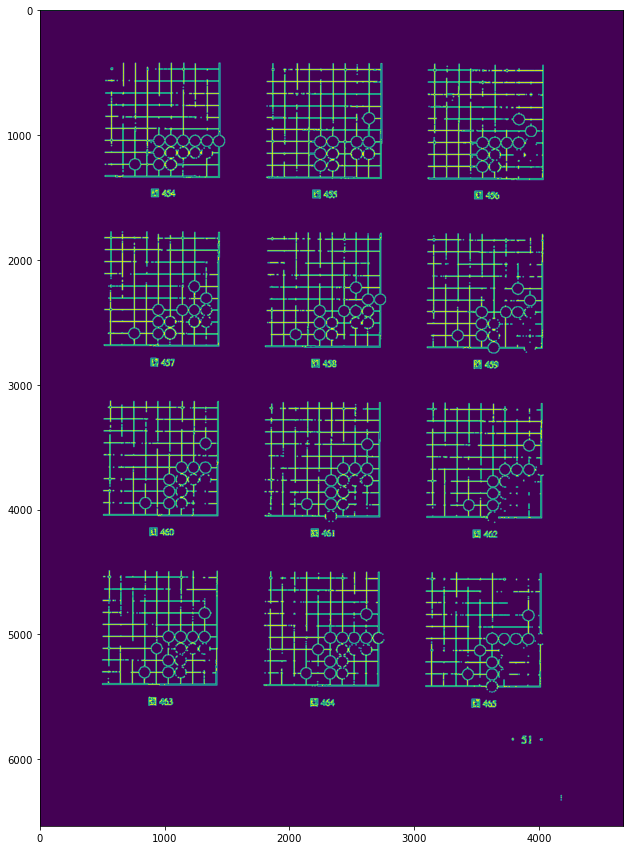

In [5]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
edges = canny_edges(img_gray)
edges = cv2.dilate(edges, np.ones((5, 5)))
plt.imshow(edges)
plt.show() 

6


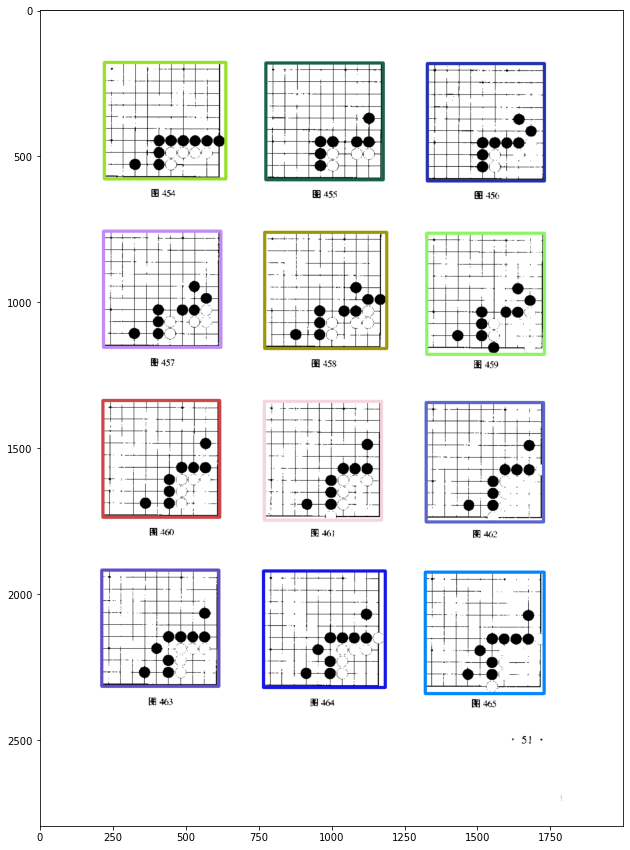

In [6]:
from random import randrange
page_img = cv2.imread(path,  cv2.IMREAD_COLOR)

MAX_PAGE_SIZE = 2000
MIN_BOARD_SIZE_COEFF = 0.1
MORPH_COEFF = 0.003
SHIFT_COEFF = 0.1
EXTRA_SIZE_COEFF = 0.05
# Preprocessing page: resize and greyscale
orig_size = min(page_img.shape[0:2])
if orig_size > MAX_PAGE_SIZE:
    scale = MAX_PAGE_SIZE / orig_size
else:
    scale = 1
page_img_crop = cv2.resize(page_img, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

# Canny edges
size = min(page_img_crop.shape[0:2])
edges = canny_edges(page_img_crop)

# For better connectivity
morph_kernel_size = round(size * MORPH_COEFF)
print(morph_kernel_size)
edges = cv2.dilate(edges, np.ones((morph_kernel_size, morph_kernel_size)))

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for i, contour in enumerate(contours):
    color = (randrange(255), randrange(255), randrange(255))
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    if perimeter > 4 * (size / 10) and area > (size / 10) ** 2:
        #cv2.drawContours(page_img_crop, [contour], 0, color, 1)
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(page_img_crop,(x,y),(x+w,y+h), color, 10)

plt.imshow(to_RGB(page_img_crop))
plt.show()

In [7]:
def sort_boards(boards, shift):
    boards.sort(key=lambda coords: coords[1])
    new_line = np.diff(boards, axis=0)[:, 1] > shift                               
    num_lines = np.sum(new_line) + 1                                               
    board_lines = [[] for _ in range(num_lines)]                                   
    line_ind = 0                                                                   
    board_lines[line_ind].append(0)                                                
    for i in range(1, len(boards)):                                                
        if new_line[i - 1]:                                                        
            line_ind += 1                                                          
        board_lines[line_ind].append(i)                                            
    for board_line in board_lines:                                                 
        board_line.sort(key=lambda ind: boards[ind][0])                            
    boards_order = np.concatenate(board_lines)
    return np.array(boards)[boards_order]                                          
                                                                                   

In [8]:
def split_into_boards(page_img):
    MAX_PAGE_SIZE = 2000
    MIN_BOARD_SIZE_COEFF = 0.1
    MORPH_COEFF = 0.003
    SHIFT_COEFF = 0.1
    EXTRA_SIZE_COEFF = 0.05
    # Preprocessing page: resize and greyscale
    orig_size = min(page_img.shape[0:2])
    if orig_size > MAX_PAGE_SIZE:
        scale = MAX_PAGE_SIZE / orig_size
    else:
        scale = 1
    page_img_crop = cv2.resize(page_img, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    # Canny edges
    size = min(page_img_crop.shape[0:2])
    edges = canny_edges(page_img_crop)

    # For better connectivity
    morph_kernel_size = round(size * MORPH_COEFF)
    edges = cv2.dilate(edges, np.ones((morph_kernel_size, morph_kernel_size)))

    # Find contours
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter boards by perimeter and area
    boards = []
    min_size = size * MIN_BOARD_SIZE_COEFF
    big_contours = set()
    for i in range(len(contours)):
        perimeter = cv2.arcLength(contours[i], True)
        area = cv2.contourArea(contours[i])
        if perimeter > 4 * min_size and area > min_size ** 2:
            big_contours.add(i)

    if len(big_contours) == 0:
        raise self.EmptyBoardsError()

    # Filter frames
    board_contours = set()
    for i in big_contours:
        inner = hierarchy[0][i][2]
        is_board = True
        while inner > 0:
            if inner in big_contours:
                is_board = False
                break
            else:
                inner = hierarchy[0][inner][0]
        if is_board:
            board_contours.add(i)
        
    for i in board_contours:
        boards.append(cv2.boundingRect(contours[i]))


    # Sort boards
    boards = sort_boards(boards, size * SHIFT_COEFF)

    # Get boards
    board_images = []
    for i, board in enumerate(boards):
        x, y, w, h = board
        extra_size = round(min(w, h) * EXTRA_SIZE_COEFF)
        board_img = page_img_crop[max(y - extra_size, 0): min(y + h + extra_size, page_img.shape[0]),
                                  max(x - extra_size, 0): min(x + w + extra_size, page_img.shape[1])]
        board_images.append(board_img)
        cv2.imwrite(f"bug_{i}.png", board_img)
    return board_images

In [9]:
page_img = cv2.imread(path, cv2.IMREAD_COLOR)
boards = split_into_boards(page_img)

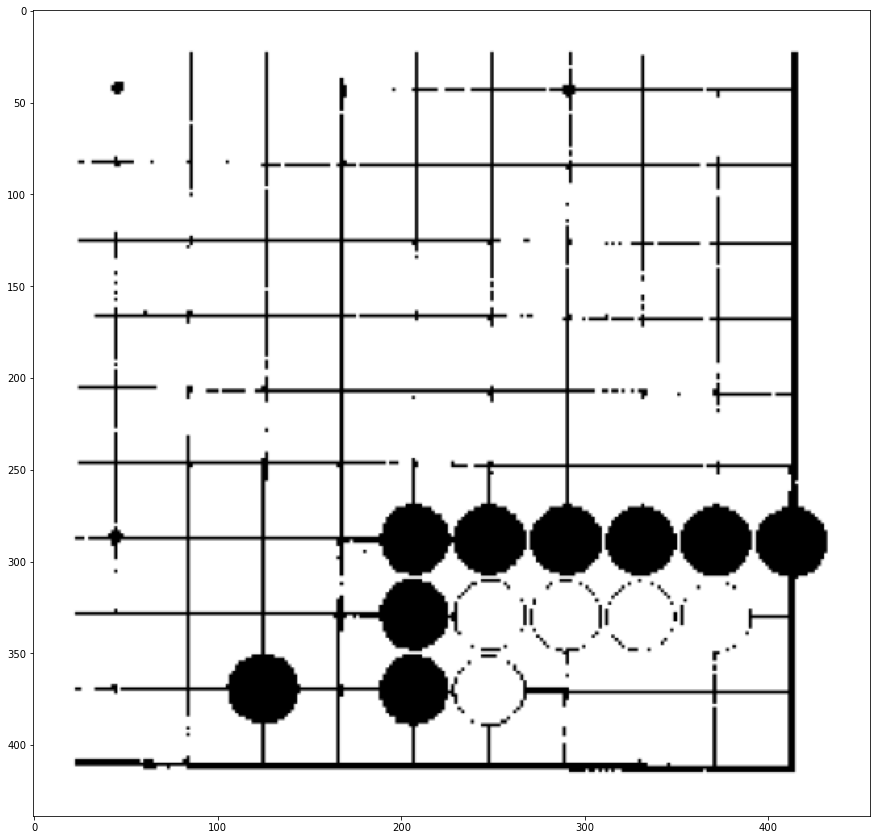

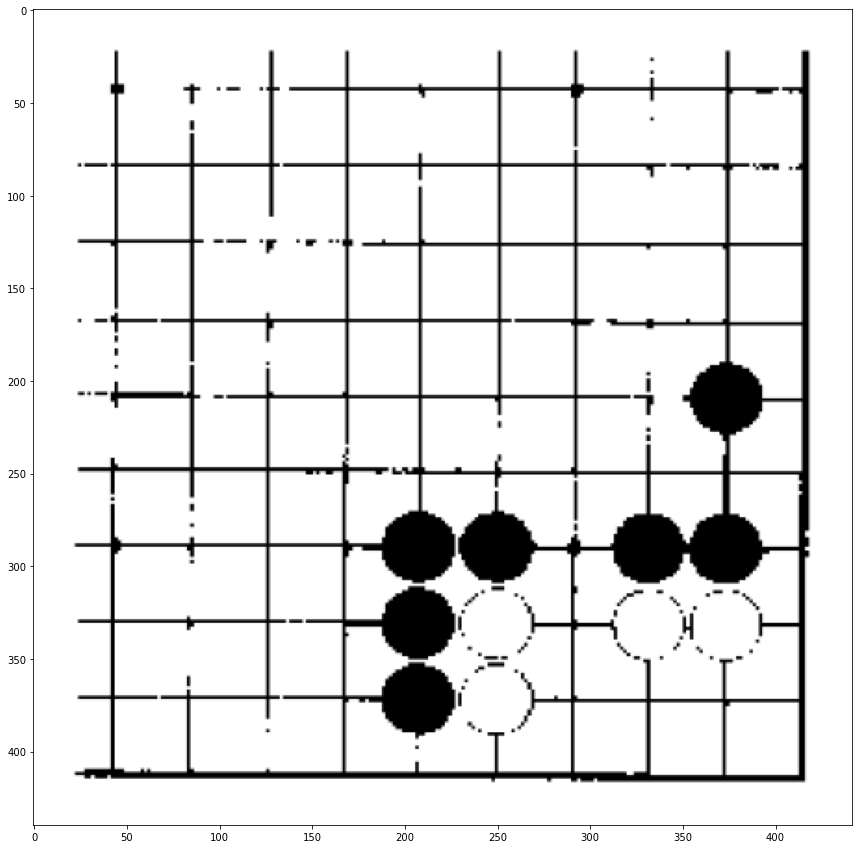

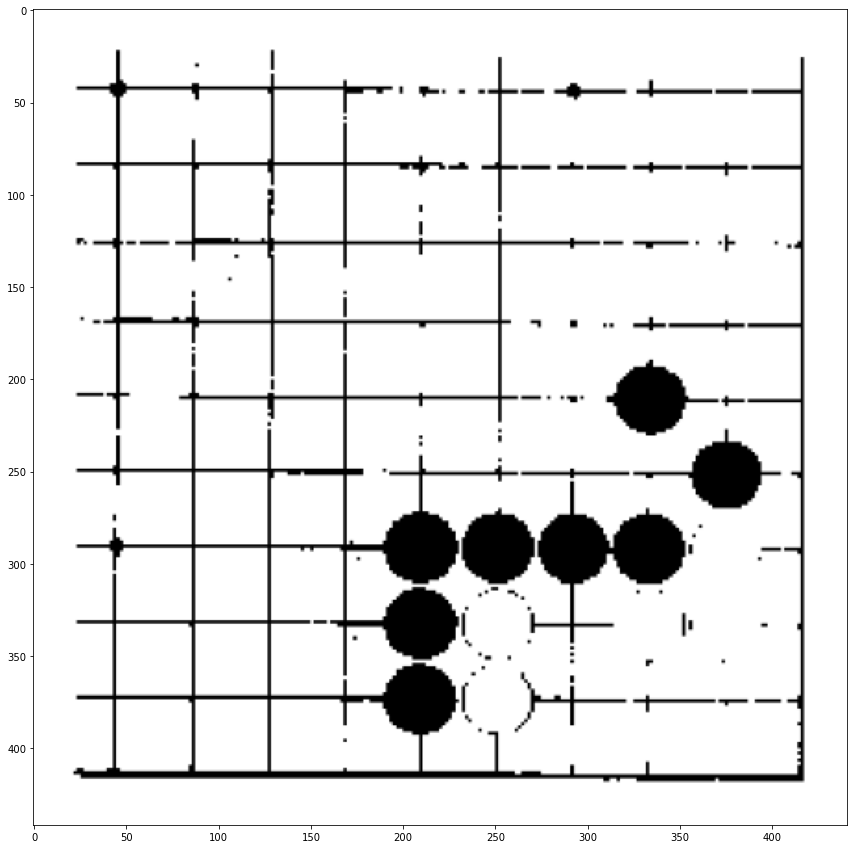

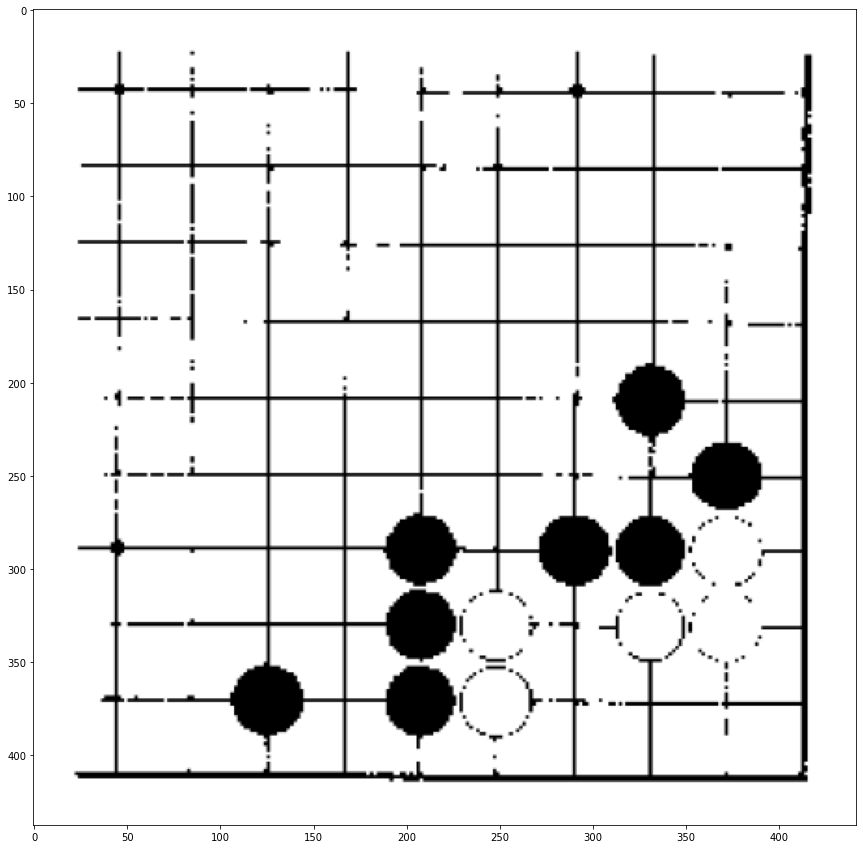

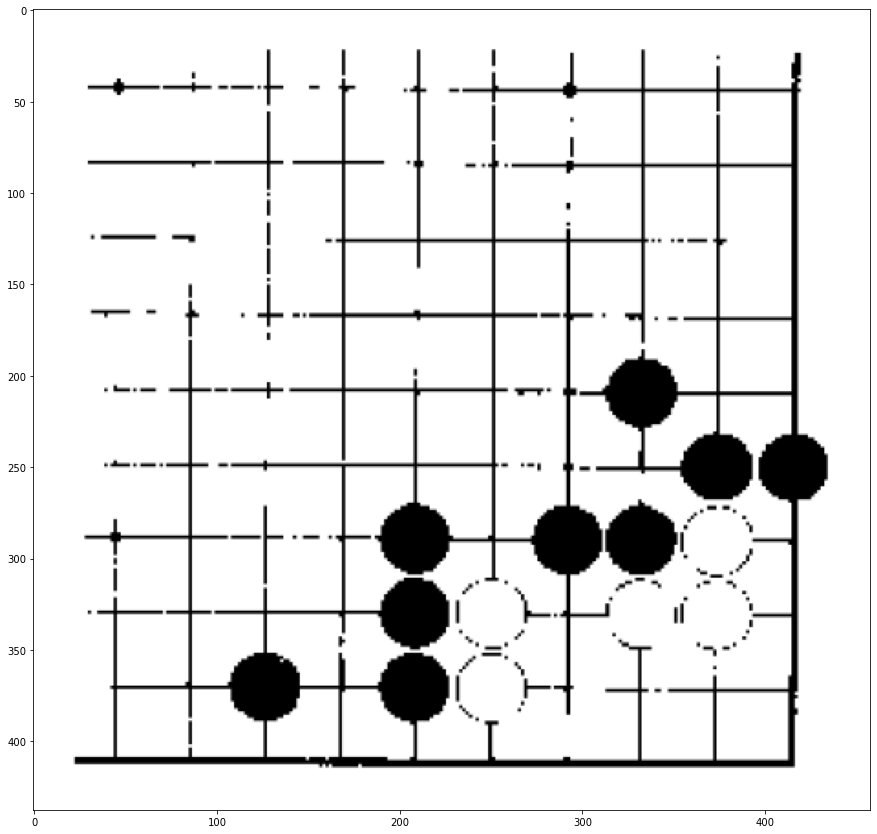

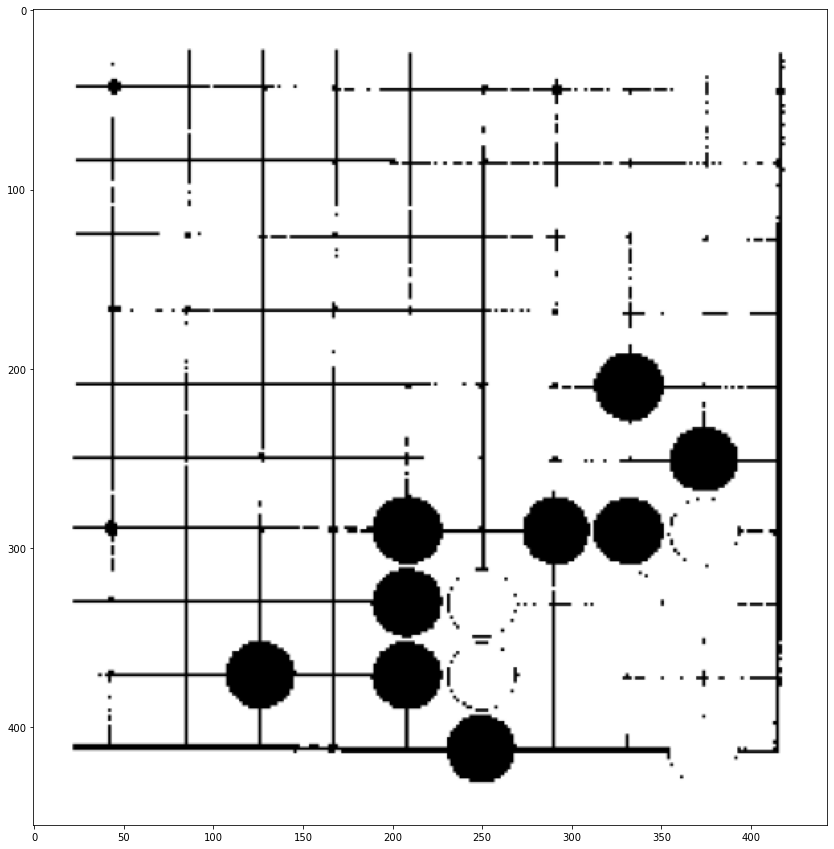

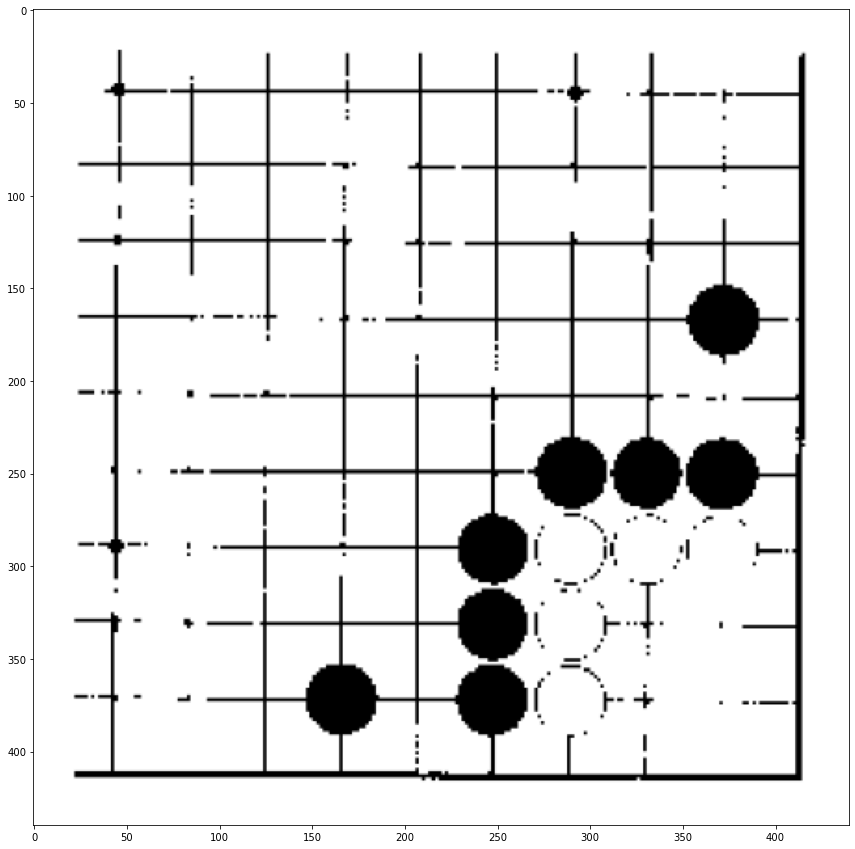

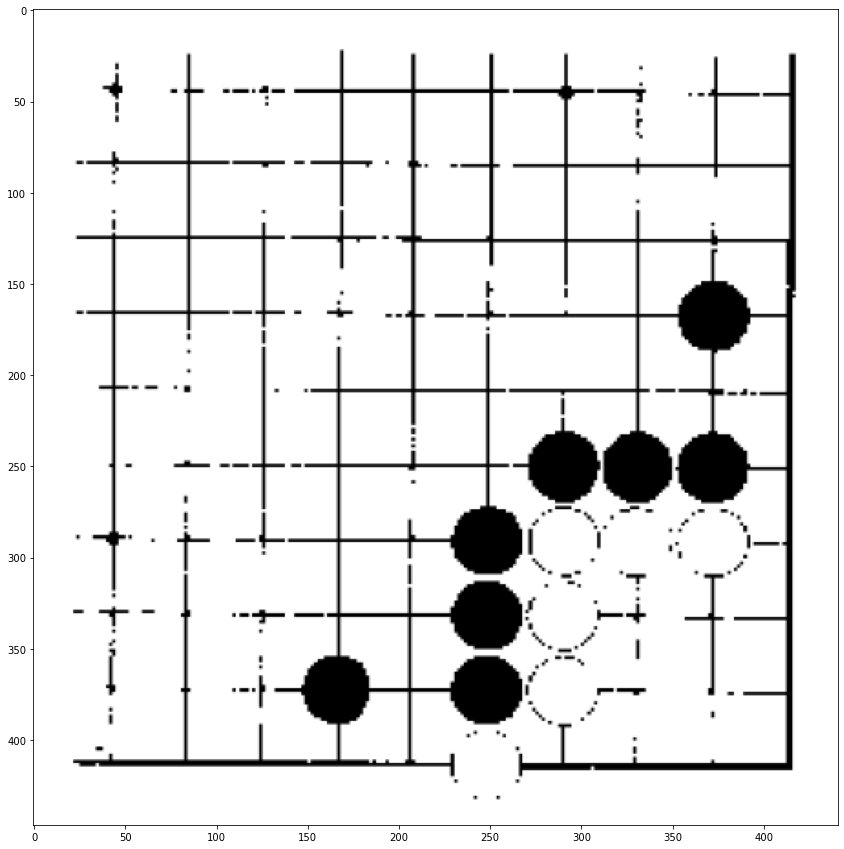

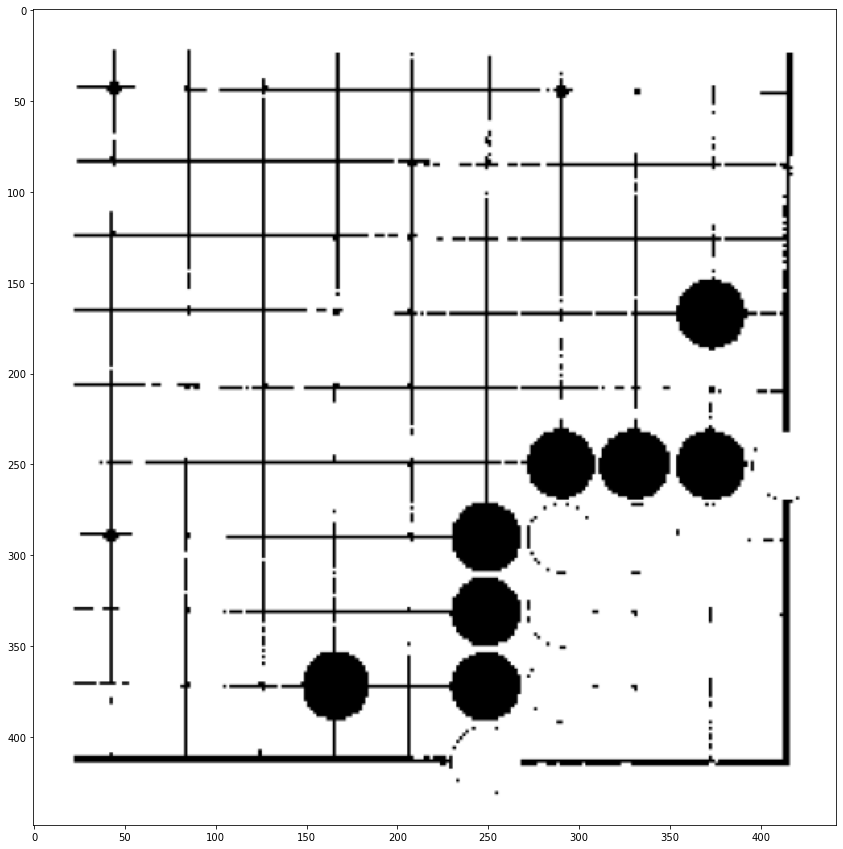

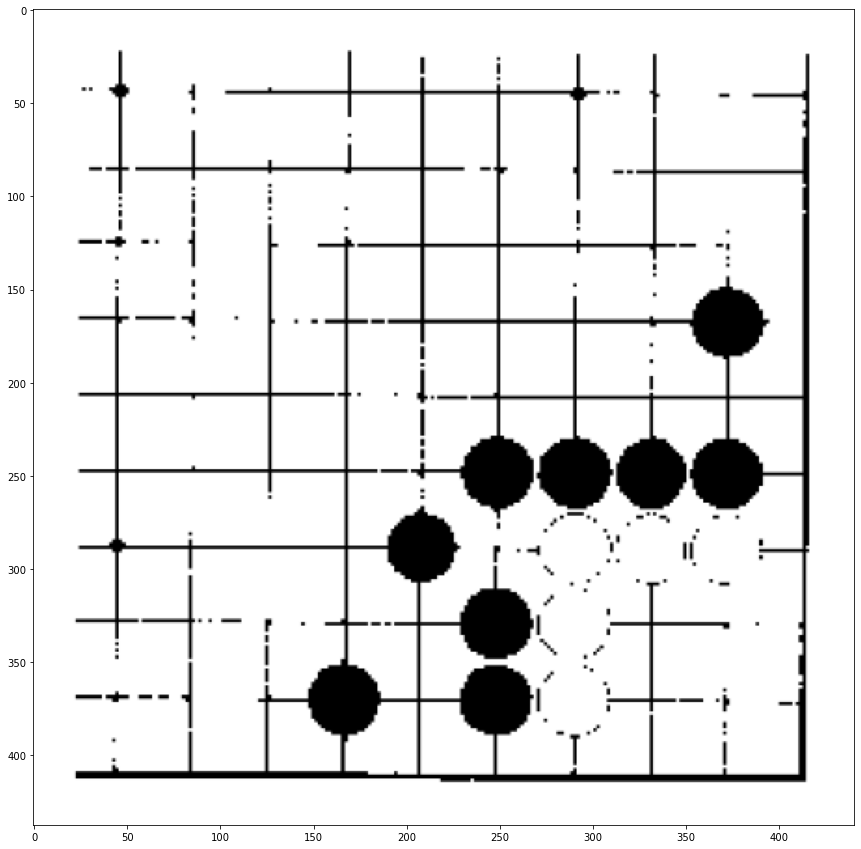

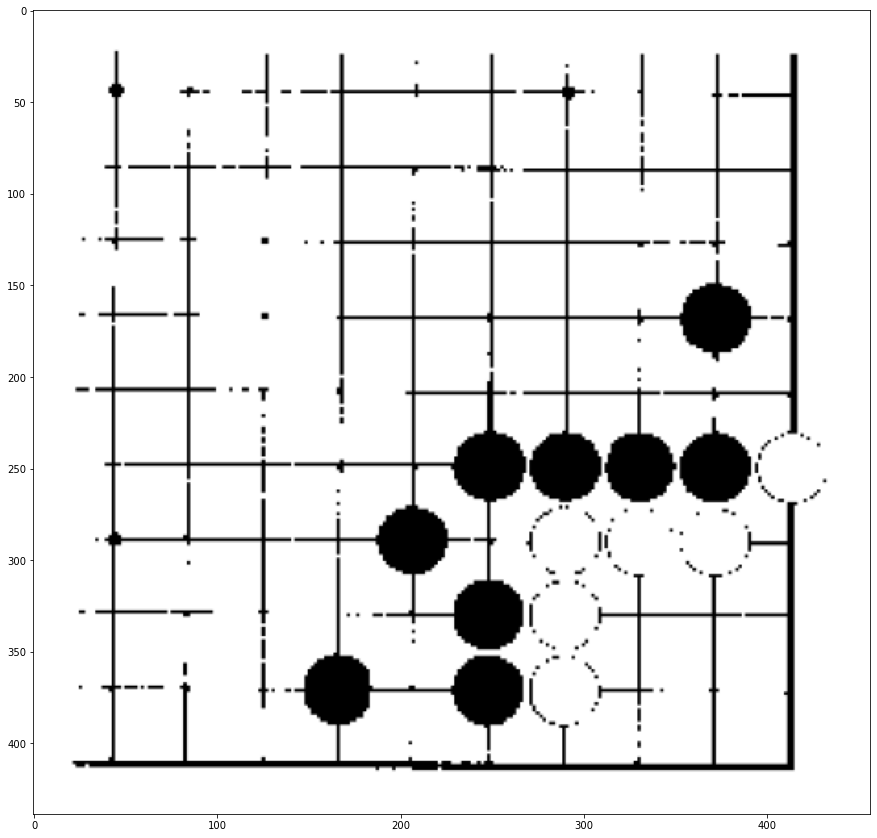

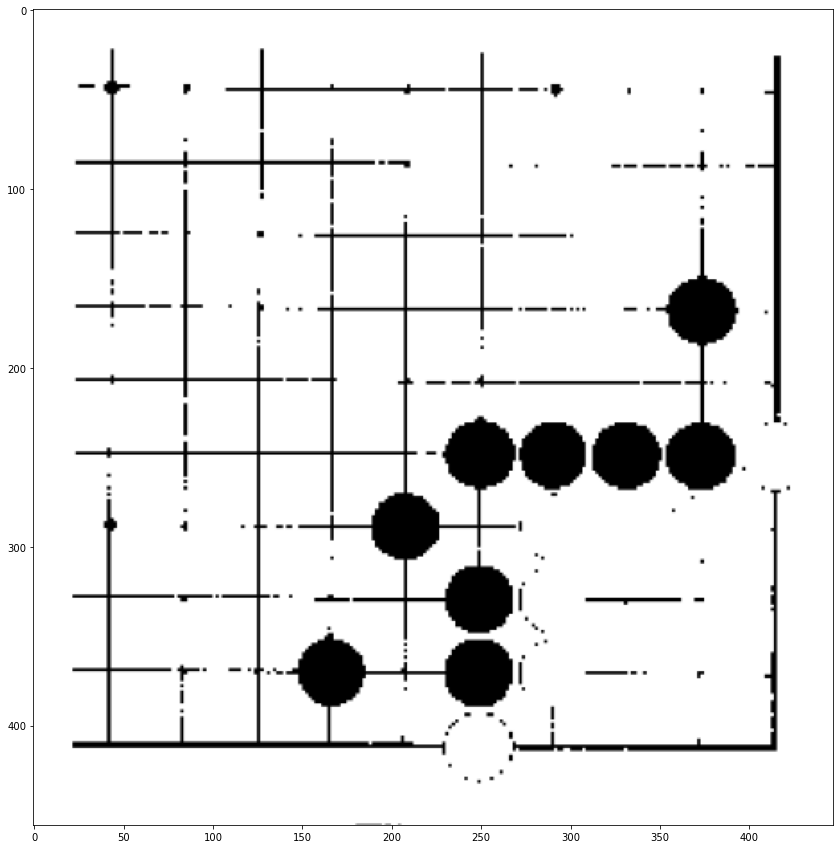

In [10]:
for board in boards:
    plt.imshow(to_RGB(board))
    plt.show()